# Libraries

In [1]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# Data scaling
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Evaluation
from sklearn.metrics import mean_squared_error

In [2]:
# Libraries for custom Transformer
from sklearn.base import BaseEstimator, TransformerMixin

# Setup

In [29]:
import os
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Data Loading

In [3]:
import pandas as pd
PATH = "dataset/melb_data.csv"

housing = pd.read_csv(PATH)

In [4]:
housing.head(2)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0


In [5]:
housing.shape

(13580, 21)

In [6]:
housing.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [7]:
X = housing.drop('Price', axis=1)
# y = housing[['Price']]
y = housing.Price

# Data Type 

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

In [9]:
# Classify numerical and categorical columns
num_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in X.columns if X[col].dtype in ['object']]
print('num_cols: ', num_cols)
print('cat_cols: ', cat_cols)
print()


card = [X[cname].nunique() for cname in cat_cols]
for a,b in zip(cat_cols, card):
    print(a, b)
    
print()

# Cols with low cardinality
low_card_cols = [col for col in cat_cols if X[col].nunique() < 10]
print('low_card_cols: ', low_card_cols)

high_card_cols = [col for col in cat_cols if X[col].nunique() >= 10]
print('high_card_cols: ', high_card_cols)

num_cols:  ['Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
cat_cols:  ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']

Suburb 314
Address 13378
Type 3
Method 5
SellerG 268
Date 58
CouncilArea 33
Regionname 8

low_card_cols:  ['Type', 'Method', 'Regionname']
high_card_cols:  ['Suburb', 'Address', 'SellerG', 'Date', 'CouncilArea']


# Data Cleaning

## Remove Unwanted Columns

In [10]:
# 1. Transfomer for deleting unwanted cols

# columns to be deleted
unwanted_cols = ['Date', 'Suburb', 'Address', 'SellerG', 'Postcode', 'haha']
# remaining cat_cols = ['Type', 'Method', 'CouncilArea', 'Regionname']

class RemoveUnwantedCatTrans(BaseEstimator, TransformerMixin):
    def __init__(self, cols = unwanted_cols):
        self.cols = cols
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
#         X_ = X.copy()
#         for col in self.cols:
#             if col in X_:
#                 X_ = X_.drop(col, axis=1, inplace=True)
        X_ = X.drop(self.cols, axis=1, errors='ignore')
#         print(X_)
        return X_

In [11]:
# Update num_cols & cat_cols once determine which cols to be removed
for col in unwanted_cols:
    if col in num_cols:
        num_cols.remove(col)
    if col in cat_cols:
        cat_cols.remove(col)
    if col in high_card_cols:
        high_card_cols.remove(col)
    if col in low_card_cols:
        low_card_cols.remove(col)
        
print('After removing unwanted columns:')
print('num_cols: ', num_cols, len(num_cols))
print('cat_cols: ', cat_cols, len(cat_cols))
print('high_card_cols: ', high_card_cols, len(high_card_cols))
print('low_card_cols: ', low_card_cols, len(low_card_cols))

After removing unwanted columns:
num_cols:  ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount'] 11
cat_cols:  ['Type', 'Method', 'CouncilArea', 'Regionname'] 4
high_card_cols:  ['CouncilArea'] 1
low_card_cols:  ['Type', 'Method', 'Regionname'] 3


## Fill NaN Values

In [12]:
imputer_col_trans = ColumnTransformer([
    ('imputer_num', SimpleImputer(strategy='median'), num_cols),
    ('imputer_col', SimpleImputer(strategy='most_frequent'), cat_cols)
])

## Pipeline

In [13]:
# Removal & Parsing Date Pipeline!!!
clean_pipe = Pipeline(steps=[
    ('rmUnwanted', RemoveUnwantedCatTrans()),
    ('imputer', imputer_col_trans),
#     ('parseDate', ParseDateTrans())
])

In [14]:
X_cleaned = pd.DataFrame(clean_pipe.fit_transform(X))
remaining_cols = num_cols + cat_cols
X_cleaned.columns = remaining_cols

In [15]:
X_cleaned.head(2)

,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Type,Method,CouncilArea,Regionname
0,2.0,2.5,2.0,1.0,1.0,202.0,126.0,1970.0,-37.7996,144.9984,4019.0,h,S,Yarra,Northern Metropolitan
1,2.0,2.5,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0,h,S,Yarra,Northern Metropolitan


In [16]:
X_ = X_cleaned[num_cols].astype('float64')
X_cleaned = X_.join(X_cleaned[cat_cols])

In [17]:
X_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          13580 non-null  float64
 1   Distance       13580 non-null  float64
 2   Bedroom2       13580 non-null  float64
 3   Bathroom       13580 non-null  float64
 4   Car            13580 non-null  float64
 5   Landsize       13580 non-null  float64
 6   BuildingArea   13580 non-null  float64
 7   YearBuilt      13580 non-null  float64
 8   Lattitude      13580 non-null  float64
 9   Longtitude     13580 non-null  float64
 10  Propertycount  13580 non-null  float64
 11  Type           13580 non-null  object 
 12  Method         13580 non-null  object 
 13  CouncilArea    13580 non-null  object 
 14  Regionname     13580 non-null  object 
dtypes: float64(11), object(4)
memory usage: 1.6+ MB


# Data Analysis

In [18]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

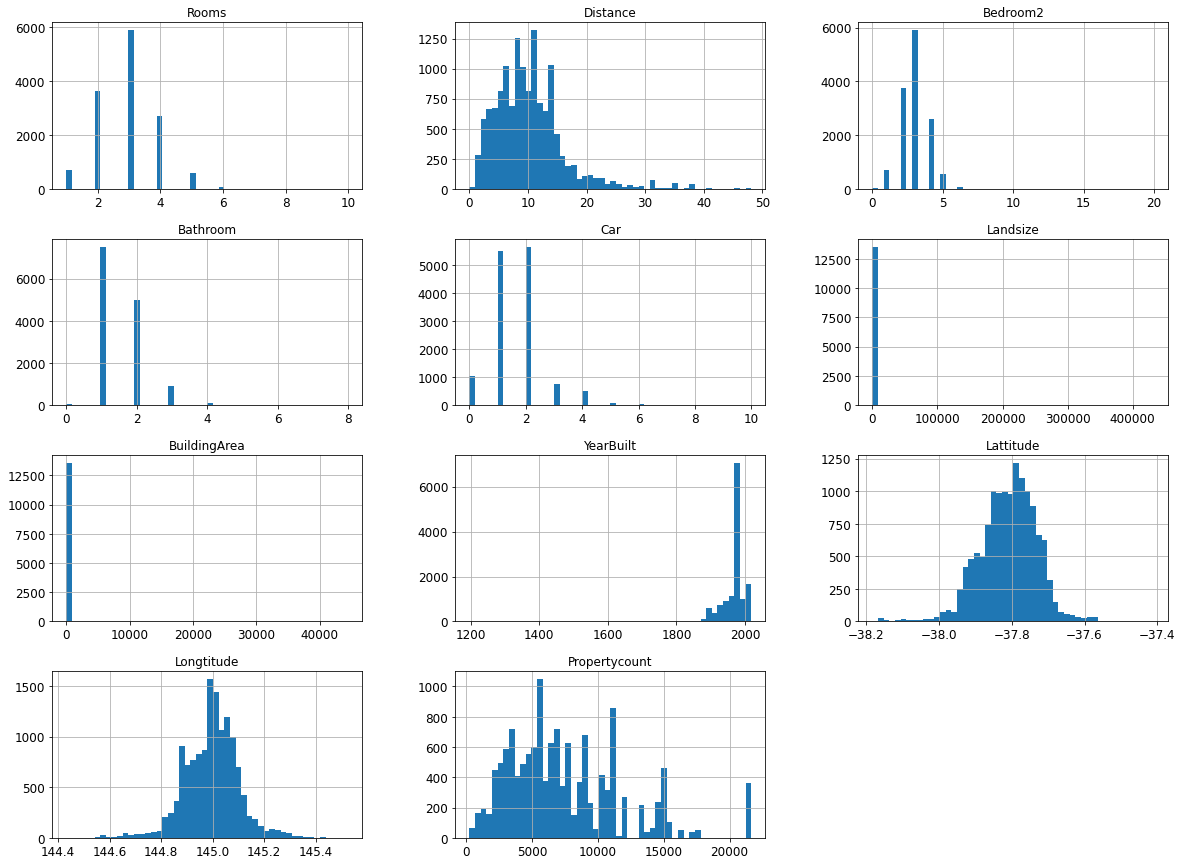

In [19]:
X_cleaned.hist(bins=50, figsize=(20, 15))
plt.show()

In [20]:
# Graph of BuidingArea & Landsize seems weird because there are outliers having very large value
print(housing.Landsize.head(10).median())
print(housing.BuildingArea.head(10).median())

168.5
124.5


In [21]:
# https://www.geeksforgeeks.org/matplotlib-pyplot-subplots-in-python/
def plot_quantile(data=None, q=0.1, ax=None, title=None, bins=20):
    # data is a dataFrame
    if ax == None:
        raise Exception('No axix "ax" is provided')
        
    low = data.quantile(0.05).values[0]
    high = data.quantile(0.95).values[0]

    ax.hist(data, bins=bins, range=(low, high))
    if title != None:
        ax.set_title(title)

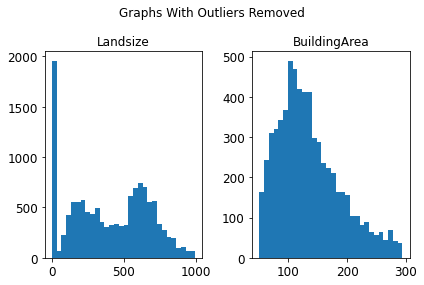

In [22]:
# Remove the outliers using quantiles and set x-axis range according to quantiles
fig, (ax1, ax2) = plt.subplots(1, 2)

plot_quantile(data=housing[['Landsize']], q=0.05, ax=ax1, title='Landsize', bins=30)
plot_quantile(data=housing[['BuildingArea']], q=0.05, ax=ax2, title='BuildingArea', bins=30)

fig.suptitle('Graphs With Outliers Removed')
fig.tight_layout()
plt.show()

In [23]:
print('max_landsize: ', max(housing.Landsize), 'min_landsize: ', min(housing.Landsize))
# print('max_buildarea: ', max(housing.BuildingArea))

max_landsize:  433014.0 min_landsize:  0.0


## Relationships

### Visualizing Geographical Data

Saving figure bad_geo_plot


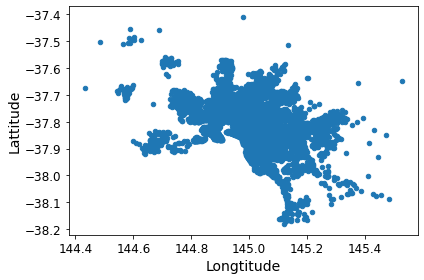

In [30]:
X_cleaned.plot(kind='scatter', x='Longtitude', y='Lattitude')
save_fig('bad_geo_plot')

Saving figure better_geo_plot


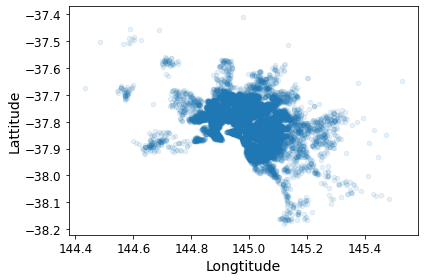

In [31]:
X_cleaned.plot(kind='scatter', x='Longtitude', y='Lattitude', alpha=0.1)
save_fig('better_geo_plot')

In [32]:
housing.iloc[0]

Suburb                      Abbotsford
Address                   85 Turner St
Rooms                                2
Type                                 h
Price                        1480000.0
Method                               S
SellerG                         Biggin
Date                         3/12/2016
Distance                           2.5
Postcode                        3067.0
Bedroom2                           2.0
Bathroom                           1.0
Car                                1.0
Landsize                         202.0
BuildingArea                       NaN
YearBuilt                          NaN
CouncilArea                      Yarra
Lattitude                     -37.7996
Longtitude                    144.9984
Regionname       Northern Metropolitan
Propertycount                   4019.0
Name: 0, dtype: object

No handles with labels found to put in legend.


Saving figure housing_prices_scatterplot


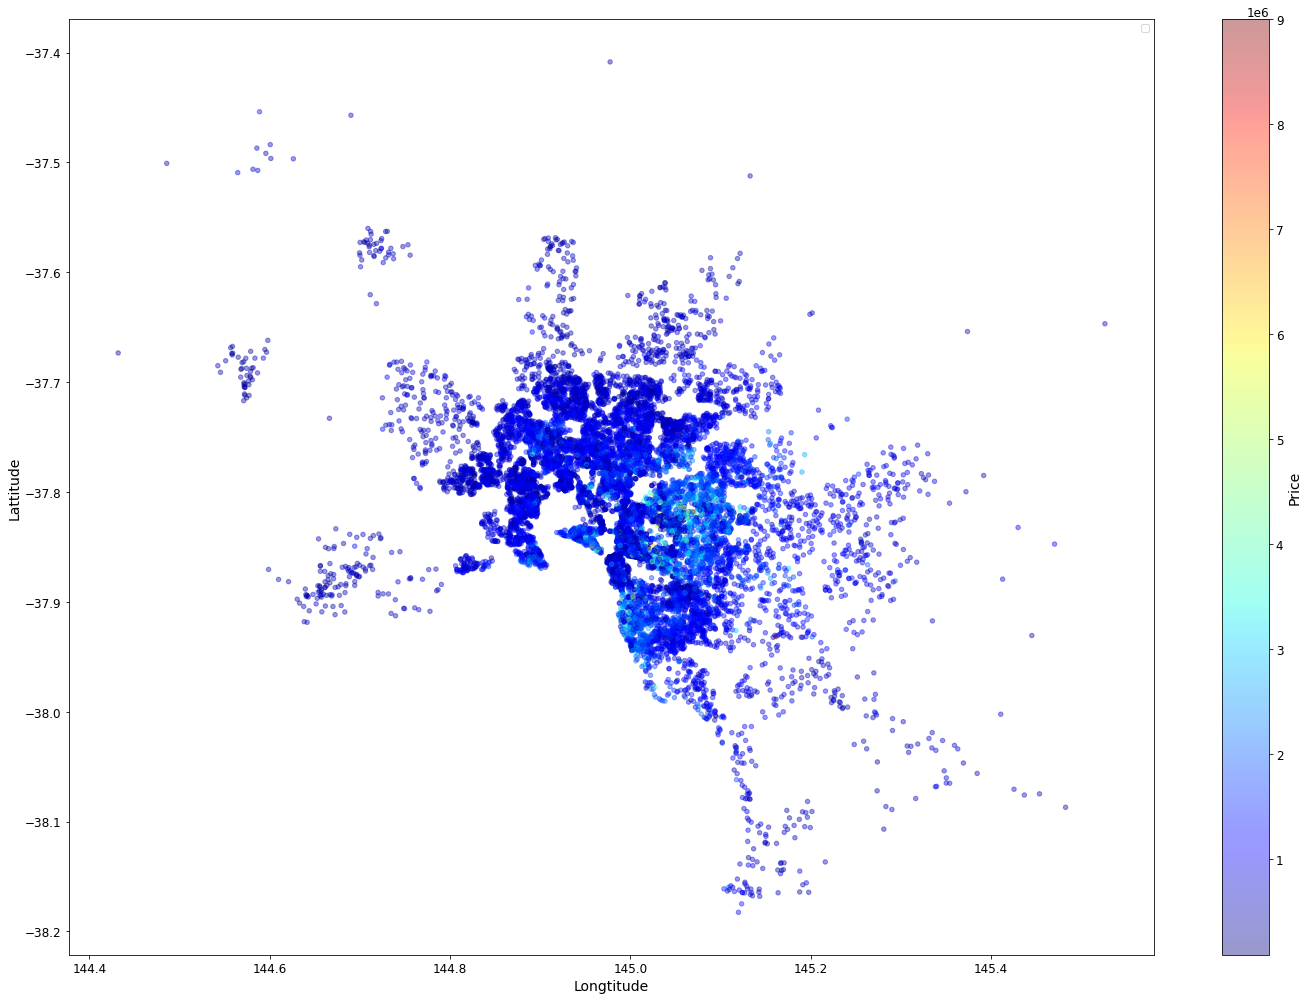

In [39]:
housing.plot(kind="scatter", x="Longtitude", y="Lattitude", alpha=0.4, figsize=(20,14),
             c="Price", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)

plt.legend()
save_fig("housing_prices_scatterplot")

In [48]:
ordinal_encoder = OrdinalEncoder()
regionname_encoded = ordinal_encoder.fit_transform(X_cleaned[['Regionname']])
regionname_encoded = pd.DataFrame(regionname_encoded, columns=['Regionname_encoded'])

In [ ]:
housing.plot(kind="scatter", x="Longtitude", y="Lattitude", alpha=0.4, figsize=(10,7),
             c="Regionname", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

# Data Split

## StratifiedShuffleSplit

In [ ]:
# Observe that 'Distance' feature has a typical distribution
# we can consider split using idea of different classes

housing['dist_cat'] = pd.cut(
    housing.Distance, 
    bins=[0., 6., 12., 18., 24., np.inf], 
    labels=[1, 2, 3, 4, 5]
)

In [ ]:
housing.dist_cat.value_counts()

In [ ]:
housing.dist_cat.hist()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["dist_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Data Split

In [ ]:
from sklearn.model_selection import train_test_split
# Seperate housing data into features and labels
y = housing.Price
X = housing.drop(['Price'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Transformer

## Numerial Trans

## Parsing Date Trans

In [ ]:
# 2. Parsing Date Transformer

# index of columns to be deleted
date_cols = ['Date']

for col in date_cols:
    if col in cat_cols:
        cat_cols.remove(col)
print('cat_cols: ', cat_cols, len(cat_cols))

In [ ]:
class ParseDateTrans(BaseEstimator, TransformerMixin):
    def __init__(self, cols = date_cols):
        self.cols = cols
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_ = X.copy()
        X_['ParsedDate'] = pd.to_datetime(X_['Date'], format="%d/%m/%y", infer_datetime_format=True)
        return X_.drop(self.cols, axis=1)

## Remove Unwanted Trans

## Categorical Trans

### High Card Trans

In [ ]:
# 3.1 High cardinality Transformer

from collections import Counter

def cumulatively_categorise(column,threshold=0.75,return_categories_list=True):
    #Find the threshold value using the percentage and number of instances in the column
    threshold_value=int(threshold*len(column))
    #Initialise an empty list for our new minimised categories
    categories_list=[]
    #Initialise a variable to calculate the sum of frequencies
    s=0
    #Create a counter dictionary of the form unique_value: frequency
    counts=Counter(column)

    #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
    for i,j in counts.most_common():
        #Add the frequency to the global sum
        s+=dict(counts)[i]
        #Append the category name to the list
        categories_list.append(i)
        #Check if the global sum has reached the threshold value, if so break the loop
        if s>=threshold_value:
            break
    #Append the category Other to the list
    categories_list.append('Other')

    #Replace all instances not in our new categories by Other  
    new_column=column.apply(lambda x: x if x in categories_list else 'Other')

    #Return transformed column and unique values if return_categories=True
    if(return_categories_list):
        return new_column,categories_list
    #Return only the transformed column if return_categories=False
    else:
        return new_column

In [ ]:
# high_card_cols = ['Regionname', 'CouncilArea']
class HighCardAggregation(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cols = high_card_cols
        pass

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        # X is a numpy array, the columns to with high cardinality
        X_ = X.copy()
        X_df = pd.DataFrame(X, columns=high_card_cols)
        
        for col in self.cols:
            # transformed_columns is a pandas dataframe
            transformed_column, trans_list = cumulatively_categorise(column=X_df[col], threshold=0.75)
#             print('transformed_column: \n', transformed_column.value_counts())
            X_ = np.c_[X_, transformed_column.to_numpy()]
            
        X_ = np.delete(X_, [i for i in range(len(self.cols))], 1)
        return X_

# Pipeline

In [ ]:
low_card_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

high_card_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('aggregation', HighCardAggregation()),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Numerical transformer
num_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Categorical transformers
cat_trans = ColumnTransformer(transformers=[
    ('low_card_pipeline', low_card_pipe, low_card_cols),
    ('high_card_pipeline', high_card_pipe, high_card_cols)
])

# # Removal & Parsing Date Pipeline!!!
# clean_pipe = Pipeline(steps=[
#     ('rmUnwanted', RemoveUnwantedCatTrans()),
#     ('imputer', imputer_col_trans),
# #     ('parseDate', ParseDateTrans())
# ])

num_cat_col_trans = ColumnTransformer(transformers=[
    ('num', num_trans, num_cols),
    ('cat', cat_trans, cat_cols)
])

preprocessor = Pipeline([
    ('cleaning', clean_pipe),
    ('num_cat', num_cat_col_trans)
])

'''
# !!!Use the full pipeline when model are ready to deploy or use!!!
# full_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
# #     ('model', LinearRegression())
#     ('model', RandomForestRegressor(n_estimators=50, random_state=42))
# ])
'''

# Testing

In [ ]:
data_prepared = preprocessor.fit_transform(X_train)
data_prepared[0]

In [ ]:
data_prepared[0].shape

In [ ]:
# # remaining cat_cols = ['Type', 'Method', 'Regionname', 'CouncilArea']
# 11 + 3 + 5 + 8 + 12 = 39

# data_prepared.shape: (10864, 39)

In [ ]:
# Just for testing!!!!!

onehot = OneHotEncoder()
cols = ['CouncilArea']
t2 = ColumnTransformer(transformers=[
#     ('low_card_pipeline', low_card_pipe, cols),
    ('high_card_pipeline', high_card_pipe, cols)
])

t1 = ColumnTransformer(transformers=[
    ('2', t2, cols)
])

p = Pipeline([
    ('1', t1)
])

p_prepared = p.fit_transform(X_train)
p_prepared[0].shape

# Model

## Load Model

In [ ]:
import joblib
import os
if os.path.isfile('models/forest_reg.pkl'):
    global forest_reg
    forest_reg = joblib.load('models/forest_reg.pkl')
    print('Load Successfull!')
#     global lin_reg = joblib.load('models/lin_reg.pkl')

## General

In [ ]:
# full_pipeline.fit(X_train, y_train)

In [ ]:
# y_pred = full_pipeline.predict(X_valid)

## Linear Regression

In [ ]:
# full_pipeline.fit(X_train, y_train)

In [ ]:
# y_pred = full_pipeline.predict(X_valid)

## Random Forest Regression 

In [ ]:
# V1 model has been saved to /models

# X_train_prepared = preprocessor.fit_transform(X_train)
# forest_reg = RandomForestRegressor(n_estimators=50, random_state=42)
# forest_reg.fit(X_train_prepared, y_train)

In [ ]:
# X_valid_prepared = preprocessor.transform(X_valid)
# y_pred = forest_reg.predict(X_valid_prepared)

## Saving Models 

In [ ]:
joblib.dump(forest_reg, 'models/forest_reg.pkl')
# joblib.dump(lin_reg, 'models/lin_reg.pkl')

# Evaluation

In [ ]:
for a,b, c in zip(y_valid.index[:10], y_valid[:10], y_pred):
    print(a, ' ', b, ' ', c)

In [ ]:
forest_rmse = mean_squared_error(y_pred, y_valid, squared=False)
forest_rmse